In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-movies-dataset/ratings.csv
/kaggle/input/the-movies-dataset/links_small.csv
/kaggle/input/the-movies-dataset/credits.csv
/kaggle/input/the-movies-dataset/keywords.csv
/kaggle/input/the-movies-dataset/movies_metadata.csv
/kaggle/input/the-movies-dataset/ratings_small.csv
/kaggle/input/the-movies-dataset/links.csv
/kaggle/input/embedding-output/output.npy


In [2]:
#pip uninstall gradio pydantic

In [3]:
 #pip install gradio pydantic

In [4]:
#import gradio as gr
import numpy as np
import os
import pandas as pd
import pickle
import torch

#from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
df_metadata = pd.read_csv("/kaggle/input/the-movies-dataset/movies_metadata.csv", low_memory=False)
df_keywords = pd.read_csv("/kaggle/input/the-movies-dataset/keywords.csv")

In [6]:
df_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [7]:
df_metadata.shape

(45466, 24)

In [8]:
df_metadata.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [9]:
df_metadata = df_metadata[
    [
        "id",
        "title",
        "genres",
        "original_language",
        "overview",
        "tagline",
        "production_countries",
        "release_date",
        "status",
        "vote_average",
        "vote_count",
        "runtime",
    ]
]

In [10]:
df_metadata[["title", "release_date"]].duplicated().sum()

32

In [11]:
df_metadata[df_metadata.overview.isnull()].shape[0]

954

In [12]:
def extract_names(data: str) -> str:
    """
    Extract the names from the data.

    :param data: A string representing a list of objects. Each object should have a 'name' key.
    :return: A string containing the names of the features, separated by commas and spaces.
    """
    if data:
        try:
            # Convert the input string to a JSON-formatted string
            json_str = json.dumps(ast.literal_eval(data))
            # Load the JSON-formatted string into a Python object
            python_obj = json.loads(json_str)
            # Extract the names from the Python object
            data_names = [data["name"] for data in python_obj]
            # Join the names into a single string separated by spaces
            data_names_str = ", ".join(data_names)

            return data_names_str

        except TypeError:
            return ""
    else:
        # If the input is empty, return an empty string
        return ""

In [13]:
def clean_movies_data_set(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the movies dataset by removing duplicates, null values and non-released movies,
    and extracting the genre names and production countries from the data.

    :param df: The movie dataset to be cleaned.
    :return: A cleaned pandas DataFrame.
    """
    print(f"The number of movies in the original data set is: {df.shape[0]}")

    # Removes duplicates titles that have same release date
    df.drop_duplicates(subset=["title", "release_date"], inplace=True)

    # Removes movies that have no overview or have not yet been released
    index_drop = df[(df.overview.isnull()) | (df.status != "Released")].index
    df.drop(index_drop, inplace=True)

    # Fills the rows with empty production_countries to NaN
    df.loc[df.production_countries == "[]", "production_countries"] = pd.NA

    # Replaces all the null values with empty string
    df.fillna("", inplace=True)

    # Extracts the genre names and production countries from the data
    df["genres"] = df["genres"].apply(extract_names)
    df["production_countries"] = df["production_countries"].apply(extract_names)

    print(f"The number of movies in the cleaned data set is: {df.shape[0]}")

    return df

In [14]:
import ast
import json
import os
import pandas as pd

In [15]:
df_metadata = clean_movies_data_set(df_metadata)

The number of movies in the original data set is: 45466
The number of movies in the cleaned data set is: 44065


In [16]:
df_keywords.columns

Index(['id', 'keywords'], dtype='object')

In [17]:
df_keywords = df_keywords.drop_duplicates()

In [18]:
df_keywords["keywords"] = df_keywords["keywords"].apply(extract_names)

In [19]:
df_keywords.head()


,id,keywords
0,862,"jealousy, toy, boy, friendship, friends, rival..."
1,8844,"board game, disappearance, based on children's..."
2,15602,"fishing, best friend, duringcreditsstinger, ol..."
3,31357,"based on novel, interracial relationship, sing..."
4,11862,"baby, midlife crisis, confidence, aging, daugh..."


In [20]:
df_metadata["id"] = df_metadata["id"].astype(int)
df_merged = pd.merge(df_keywords, df_metadata, on="id")

In [21]:
df_merged.head()

,id,keywords,title,genres,original_language,overview,tagline,production_countries,release_date,status,vote_average,vote_count,runtime
0,862,"jealousy, toy, boy, friendship, friends, rival...",Toy Story,"Animation, Comedy, Family",en,"Led by Woody, Andy's toys live happily in his ...",,United States of America,1995-10-30,Released,7.7,5415.0,81.0
1,8844,"board game, disappearance, based on children's...",Jumanji,"Adventure, Fantasy, Family",en,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,United States of America,1995-12-15,Released,6.9,2413.0,104.0
2,15602,"fishing, best friend, duringcreditsstinger, ol...",Grumpier Old Men,"Romance, Comedy",en,A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,United States of America,1995-12-22,Released,6.5,92.0,101.0
3,31357,"based on novel, interracial relationship, sing...",Waiting to Exhale,"Comedy, Drama, Romance",en,"Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...,United States of America,1995-12-22,Released,6.1,34.0,127.0
4,11862,"baby, midlife crisis, confidence, aging, daugh...",Father of the Bride Part II,Comedy,en,Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...,United States of America,1995-02-10,Released,5.7,173.0,106.0


In [22]:
def create_soup(movie: pd.Series) -> str:
    """
    Concatenates several movies features into a single string to create a soup of text.

    :param movie: A movie containing features to concatenate.
    :return: A string containing the concatenated movie features.
    """
    return (
        movie.title 
        +" "
        +
        movie.genres
        + " "
        + movie.overview
        + " "
        + movie.tagline
        + " "
        + movie.keywords
        
    ).lower()

In [23]:
df_merged["soup"] = df_merged.apply(create_soup, axis=1)

In [24]:

# Define the linear transformation function
def scale_rating(x):
    x_min = 0
    x_max = 10
    y_min = 1
    y_max = 5
    scaled_rating=(x - x_min) * (y_max - y_min) / (x_max - x_min) + y_min
    return round(scaled_rating,2)

# Apply the transformation to the 'vote_average' column
df_merged['scaled_votes'] = df_merged['vote_average'].apply(scale_rating)



In [25]:
df_merged.head()

,id,keywords,title,genres,original_language,overview,tagline,production_countries,release_date,status,vote_average,vote_count,runtime,soup,scaled_votes
0,862,"jealousy, toy, boy, friendship, friends, rival...",Toy Story,"Animation, Comedy, Family",en,"Led by Woody, Andy's toys live happily in his ...",,United States of America,1995-10-30,Released,7.7,5415.0,81.0,"toy story animation, comedy, family led by woo...",4.08
1,8844,"board game, disappearance, based on children's...",Jumanji,"Adventure, Fantasy, Family",en,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,United States of America,1995-12-15,Released,6.9,2413.0,104.0,"jumanji adventure, fantasy, family when siblin...",3.76
2,15602,"fishing, best friend, duringcreditsstinger, ol...",Grumpier Old Men,"Romance, Comedy",en,A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,United States of America,1995-12-22,Released,6.5,92.0,101.0,"grumpier old men romance, comedy a family wedd...",3.60
3,31357,"based on novel, interracial relationship, sing...",Waiting to Exhale,"Comedy, Drama, Romance",en,"Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...,United States of America,1995-12-22,Released,6.1,34.0,127.0,"waiting to exhale comedy, drama, romance cheat...",3.44
4,11862,"baby, midlife crisis, confidence, aging, daugh...",Father of the Bride Part II,Comedy,en,Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...,United States of America,1995-02-10,Released,5.7,173.0,106.0,father of the bride part ii comedy just when g...,3.28


In [26]:
mean_vote_average_C = df_merged["scaled_votes"].mean()
mean_vote_average_C

3.2576751997095137

In [27]:
min_vote_counts_m = df_merged["vote_count"].quantile(0.9)
min_vote_counts_m

167.0

In [28]:
df_qualified = df_merged.loc[df_merged["vote_count"] >= min_vote_counts_m]
df_qualified.shape

(4418, 15)

In [29]:
def calculate_weighted_rating(
    movie: pd.Series, min_vote_counts_m: int, mean_vote_average_C: float
) -> float:
    """
    Calculate the weighted rating for a movie based on its vote count, vote average,
    and the minimum vote counts and mean vote average across the dataset.

    :param movie: A DataFrame row representing a movie.
    :param min_votes: The mnimum votes required to be listed in the chart.
    :param mean_vote_average: The mean vote average across the whole dataset.
    :return: The weighted rating for the movie.
    """
    vote_count = movie["vote_count"]
    vote_average = movie["scaled_votes"]

    weighted_rating = (vote_count / (vote_count + min_vote_counts_m) * vote_average) + (
        min_vote_counts_m / (min_vote_counts_m + vote_count) * mean_vote_average_C
    )
    
    weighted_rating = round(weighted_rating, 1)
    return weighted_rating

In [30]:
df_merged["weighted_rating"] = df_merged.apply(
    lambda movie: calculate_weighted_rating(
        movie, min_vote_counts_m, mean_vote_average_C
    ),
    axis=1,
)

In [31]:
df_merged.head(10)

,id,keywords,title,genres,original_language,overview,tagline,production_countries,release_date,status,vote_average,vote_count,runtime,soup,scaled_votes,weighted_rating
0,862,"jealousy, toy, boy, friendship, friends, rival...",Toy Story,"Animation, Comedy, Family",en,"Led by Woody, Andy's toys live happily in his ...",,United States of America,1995-10-30,Released,7.7,5415.0,81.0,"toy story animation, comedy, family led by woo...",4.08,4.1
1,8844,"board game, disappearance, based on children's...",Jumanji,"Adventure, Fantasy, Family",en,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,United States of America,1995-12-15,Released,6.9,2413.0,104.0,"jumanji adventure, fantasy, family when siblin...",3.76,3.7
2,15602,"fishing, best friend, duringcreditsstinger, ol...",Grumpier Old Men,"Romance, Comedy",en,A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,United States of America,1995-12-22,Released,6.5,92.0,101.0,"grumpier old men romance, comedy a family wedd...",3.60,3.4
3,31357,"based on novel, interracial relationship, sing...",Waiting to Exhale,"Comedy, Drama, Romance",en,"Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...,United States of America,1995-12-22,Released,6.1,34.0,127.0,"waiting to exhale comedy, drama, romance cheat...",3.44,3.3
4,11862,"baby, midlife crisis, confidence, aging, daugh...",Father of the Bride Part II,Comedy,en,Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...,United States of America,1995-02-10,Released,5.7,173.0,106.0,father of the bride part ii comedy just when g...,3.28,3.3
5,949,"robbery, detective, bank, obsession, chase, sh...",Heat,"Action, Crime, Drama, Thriller",en,"Obsessive master thief, Neil McCauley leads a ...",A Los Angeles Crime Saga,United States of America,1995-12-15,Released,7.7,1886.0,170.0,"heat action, crime, drama, thriller obsessive ...",4.08,4.0
6,11860,"paris, brother brother relationship, chauffeur...",Sabrina,"Comedy, Romance",en,An ugly duckling having undergone a remarkable...,You are cordially invited to the most surprisi...,"Germany, United States of America",1995-12-15,Released,6.2,141.0,127.0,"sabrina comedy, romance an ugly duckling havin...",3.48,3.4
7,45325,,Tom and Huck,"Action, Adventure, Drama, Family",en,"A mischievous young boy, Tom Sawyer, witnesses...",The Original Bad Boys.,United States of America,1995-12-22,Released,5.4,45.0,97.0,"tom and huck action, adventure, drama, family ...",3.16,3.2
8,9091,"terrorist, hostage, explosive, vice president",Sudden Death,"Action, Adventure, Thriller",en,International action superstar Jean Claude Van...,Terror goes into overtime.,United States of America,1995-12-22,Released,5.5,174.0,106.0,"sudden death action, adventure, thriller inter...",3.20,3.2
9,710,"cuba, falsely accused, secret identity, comput...",GoldenEye,"Adventure, Action, Thriller",en,James Bond must unmask the mysterious head of ...,No limits. No fears. No substitutes.,"United Kingdom, United States of America",1995-11-16,Released,6.6,1194.0,130.0,"goldeneye adventure, action, thriller james bo...",3.64,3.6


In [32]:
pip install sentence-transformers


  Obtaining dependency information for sentence-transformers from https://files.pythonhosted.org/packages/76/2c/bd95032aeb087b0706596af0a4518c4bfe0439a1bb149048ece18b617766/sentence_transformers-2.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [33]:
#import gradio as gr
import numpy as np
import os
import pandas as pd
import pickle
import torch

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = SentenceTransformer("bert-base-nli-mean-tokens").to(device)





modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [35]:
#if you are running for first uncomment this cell
#sentence_embeddings = model.encode(df_merged["soup"].tolist())

In [ ]:
#sentence_embeddings.shape
#save it in local directory for the faster execution


In [37]:
sentence_embeddings = np.load('/kaggle/input/embedding-output/output.npy') #for future sessions
#Compute similarity


In [38]:
from sklearn.metrics.pairwise import cosine_similarity

In [39]:
#uncomment this if your are running for first time
cos_sim=cosine_similarity(sentence_embeddings)

In [40]:
movie_indices = pd.Series(
    df_merged.index, index=df_merged["title"].apply(lambda title: title.lower())
).drop_duplicates()
movie_indices.head()

title
toy story                      0
jumanji                        1
grumpier old men               2
waiting to exhale              3
father of the bride part ii    4
dtype: int64

**collabarative Filtering**

In [41]:
ratings=pd.read_csv('/kaggle/input/the-movies-dataset/ratings_small.csv')

In [42]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [43]:
m=ratings['movieId'].value_counts()

In [44]:
m

movieId
356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: count, Length: 9066, dtype: int64

In [45]:
df_merged[df_merged['id']==296]

,id,keywords,title,genres,original_language,overview,tagline,production_countries,release_date,status,vote_average,vote_count,runtime,soup,scaled_votes,weighted_rating
6332,296,"saving the world, artificial intelligence, man...",Terminator 3: Rise of the Machines,"Action, Thriller, Science Fiction",en,It's been 10 years since John Connor saved Ear...,The Machines Will Rise.,"Germany, United Kingdom, United States of America",2003-07-02,Released,5.9,2177.0,109.0,"terminator 3: rise of the machines action, thr...",3.36,3.4


In [46]:
#most popular movie 
movie_ratings_count = ratings.groupby('movieId').size()

# Sort the movies by the number of ratings in descending order to find the most popular ones
popular_movies = movie_ratings_count.sort_values(ascending=False)

# Extract the most popular movie (the one with the highest number of ratings)
most_popular_movie_id = popular_movies.index[0]  # Most popular movie's ID
most_popular_movie_count = popular_movies.iloc[0]  # Number of ratings for the most popular movie

# Print or return the result
print("The most popular movie is Movie ID:", most_popular_movie_id)
print("Number of ratings:", most_popular_movie_count)

The most popular movie is Movie ID: 356
Number of ratings: 341


In [47]:
ratings[ratings['movieId']==1371]

,userId,movieId,rating,timestamp
10,1,1371,2.5,1260759135
234,4,1371,4.0,949810302
574,7,1371,3.0,851869160
3504,19,1371,4.0,855193404
3775,21,1371,3.0,853852263
3845,22,1371,2.0,1131662302
6931,41,1371,3.5,1093886662
12415,78,1371,4.0,1344470332
17578,118,1371,3.0,951009005
19508,130,1371,3.0,1138999999


In [48]:
#no.of unique users
ratings['userId'].nunique()

671

In [49]:
#no . of uniques movies 
ratings['movieId'].nunique()

9066

In [50]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [51]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [52]:
ratings.duplicated().sum()

0

In [53]:
movies=pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')

/tmp/ipykernel_42/3982945378.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies=pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')


In [54]:
len(movies['title'].unique())

42278

In [55]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [56]:
movies.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [57]:
movies.shape

(45466, 24)

In [58]:
movies = movies[
    [
        "id",
        "title",
        "genres",
        "overview"
    ]
]

In [59]:
movies.isnull().sum()

id            0
title         6
genres        0
overview    954
dtype: int64

In [60]:
movies.shape

(45466, 4)

In [61]:
import pandas as pd

duplicate_rows = movies.duplicated()

print(duplicate_rows)
duplicate_rows_data = movies[duplicate_rows]


0        False
1        False
2        False
3        False
4        False
         ...  
45461    False
45462    False
45463    False
45464    False
45465    False
Length: 45466, dtype: bool


In [62]:
duplicate_rows_data

,id,title,genres,overview
1465,105045,The Promise,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...","East-Berlin, 1961, shortly after the erection ..."
9165,5511,Le Samouraï,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",Hitman Jef Costello is a perfectionist who alw...
9327,23305,The Warrior,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...","In feudal India, a warrior (Khan) who renounce..."
12066,14788,Bubble,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",Set against the backdrop of a decaying Midwest...
13375,141971,Blackout,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",Recovering from a nail gun shot to the head an...
15074,22649,A Farewell to Arms,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",British nurse Catherine Barkley (Helen Hayes) ...
15765,13209,Offside,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...","Since women are banned from soccer matches, Ir..."
16764,141971,Blackout,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",Recovering from a nail gun shot to the head an...
20843,77221,Black Gold,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...","On the Arabian Peninsula in the 1930s, two war..."
20899,109962,Rich and Famous,"[{'id': 18, 'name': 'Drama'}]",Two literary women compete for 20 years: one w...


In [63]:
movies.drop_duplicates(inplace=True)

In [64]:

duplicate_rows = movies.duplicated(subset=['title'])

duplicate_rows_data = movies[duplicate_rows]


In [65]:
movies.drop_duplicates(subset=['title'],inplace=True)

In [66]:
movies.rename(columns={'id': 'movieId'}, inplace=True)

In [67]:
movies.shape

(42278, 4)

In [68]:
movies.columns

Index(['movieId', 'title', 'genres', 'overview'], dtype='object')

In [69]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42278 entries, 0 to 45465
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movieId   42278 non-null  object
 1   title     42277 non-null  object
 2   genres    42278 non-null  object
 3   overview  41363 non-null  object
dtypes: object(4)
memory usage: 1.6+ MB


In [70]:
movies['movieId']=movies['movieId'].astype('Int64')

In [71]:
movies.head()

,movieId,title,genres,overview
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ..."
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom..."
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...


In [72]:
movies.columns

Index(['movieId', 'title', 'genres', 'overview'], dtype='object')

In [73]:
movies['title']=movies['title'].str.lower()

In [74]:
movies['title'].nunique()

42227

In [75]:
ratings[ratings['movieId']==40244]

,userId,movieId,rating,timestamp


In [76]:
df_no_duplicates = movies.drop_duplicates(subset=['movieId'])


In [77]:
merged=ratings.merge(df_no_duplicates,on='movieId')

In [78]:
 merged["genres"] = merged["genres"].apply(extract_names)

In [79]:
merged

,userId,movieId,rating,timestamp,title,genres,overview
0,1,1371,2.5,1260759135,rocky iii,Drama,"Now the world champion, Rocky Balboa is living..."
1,4,1371,4.0,949810302,rocky iii,Drama,"Now the world champion, Rocky Balboa is living..."
2,7,1371,3.0,851869160,rocky iii,Drama,"Now the world champion, Rocky Balboa is living..."
3,19,1371,4.0,855193404,rocky iii,Drama,"Now the world champion, Rocky Balboa is living..."
4,21,1371,3.0,853852263,rocky iii,Drama,"Now the world champion, Rocky Balboa is living..."
...,...,...,...,...,...,...,...
42824,652,127728,5.0,1439586990,8:46,Drama,A glimpse into the lives of an ensemble of cha...
42825,652,129009,4.0,1442690827,love is a ball,"Comedy, Romance",Etienne makes a good living out of marrying of...
42826,659,167,4.0,836137550,k-pax,"Drama, Science Fiction",Prot is a patient at a mental hospital who cla...
42827,659,563,3.0,834694187,starship troopers,"Adventure, Action, Thriller, Science Fiction","Set in the future, the story follows a young s..."


In [80]:
rand=merged['title'].nunique

In [81]:
unique_titles = merged['title'].unique()


In [82]:
merged.head()

,userId,movieId,rating,timestamp,title,genres,overview
0,1,1371,2.5,1260759135,rocky iii,Drama,"Now the world champion, Rocky Balboa is living..."
1,4,1371,4.0,949810302,rocky iii,Drama,"Now the world champion, Rocky Balboa is living..."
2,7,1371,3.0,851869160,rocky iii,Drama,"Now the world champion, Rocky Balboa is living..."
3,19,1371,4.0,855193404,rocky iii,Drama,"Now the world champion, Rocky Balboa is living..."
4,21,1371,3.0,853852263,rocky iii,Drama,"Now the world champion, Rocky Balboa is living..."


In [83]:
merged['userId'].nunique()

671

In [84]:
# Convert lists l1 and l2 into sets
l1=ratings['movieId']
l2=movies['movieId']
set1 = set(l1)
set2 = set(l2)

# Perform intersection using the intersection() method
intersection_set = set1.intersection(set2)

# Or perform intersection using the & operator
# intersection_set = set1 & set2

# Convert the intersection set back to a list if needed
intersection_list = list(intersection_set)
intersection_list.sort()
# Print the intersection list
print("Intersection of movieIds:", intersection_list[:50])


Intersection of movieIds: [2, 3, 5, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 35, 38, 55, 58, 59, 62, 63, 64, 65, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 80, 81, 82, 83, 85, 86, 87, 88, 89]


In [85]:
ratings[ratings['movieId']==89]

,userId,movieId,rating,timestamp
3138,19,89,3.0,855193220
4021,23,89,4.0,1148669357
12684,80,89,3.0,844860250
17355,113,89,4.0,844884932
19027,128,89,5.0,1049683332
24528,177,89,4.0,907380994
29279,213,89,3.5,1462644085
43360,311,89,3.0,898008016
61460,452,89,3.0,976424143
70282,487,89,3.0,832838523


In [86]:
movies[movies['movieId']==89]

,movieId,title,genres,overview
1246,89,indiana jones and the last crusade,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",When Dr. Henry Jones Sr. suddenly goes missing...


In [87]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
Ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# I need to de-normalize the data (normalize by each users mean) and convert it from a dataframe to a numpy array.
R = Ratings.values
user_ratings_mean = np.mean(R, axis=1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)


In [89]:
Ratings_demeaned.shape

(671, 9066)

In [90]:
#finding out the sparsity of the matrix
sparsity = round(1.0 - len(ratings) / float(671 * 9066), 3)

In [91]:
sparsity*100

98.4

thrugh this we conclude that our ratings matrix is hugely sparsed
#svd
 well-known matrix factorization method is Singular value decomposition (SVD). At a high level, SVD is an algorithm that decomposes a matrix 
 into the best lower rank (i.e. smaller/simpler) approximation of the original matrix Mathematically, it decomposes A into a two unitary matrices and a diagonal matrix:



In [92]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(Ratings_demeaned, k = 10)

In [93]:
sigma = np.diag(sigma)

In [94]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [95]:
all_user_predicted_ratings

array([[-4.02560319e-03,  3.01107320e-04,  1.74141839e-02, ...,
        -4.75097887e-03, -4.41112561e-03,  5.36971090e-04],
       [ 1.62201619e+00,  1.58260769e+00,  6.30465426e-01, ...,
        -3.16042833e-03, -2.98672153e-03,  2.14905922e-02],
       [ 1.10572982e+00,  4.09862816e-01,  8.95391122e-02, ...,
         8.62363156e-03,  7.05421697e-03, -2.66611410e-02],
       ...,
       [ 2.17507197e-01,  4.60802887e-02,  3.11067019e-02, ...,
        -3.71812279e-03, -3.72062814e-03, -1.62050786e-02],
       [ 7.92392355e-01,  3.40876481e-01,  1.16531892e-01, ...,
         2.27942511e-03,  1.63988802e-03, -2.41860030e-02],
       [ 2.26945424e+00,  3.91699865e-01,  3.65037576e-02, ...,
         5.30518088e-03,  2.64594696e-03, -8.44651190e-02]])

In [96]:
Ratings.columns

Index([     1,      2,      3,      4,      5,      6,      7,      8,      9,
           10,
       ...
       161084, 161155, 161594, 161830, 161918, 161944, 162376, 162542, 162672,
       163949],
      dtype='int64', name='movieId', length=9066)

In [97]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.004026,0.000301,0.017414,0.000285,-0.000066,0.030387,0.013093,-0.008394,0.002473,0.012373,...,-0.001682,-0.002974,0.005209,-0.000725,0.000864,-0.003067,0.009764,-0.004751,-0.004411,0.000537
1,1.622016,1.582608,0.630465,0.175916,0.621545,1.232557,0.637712,0.077973,0.334632,1.939569,...,0.009382,-0.002088,0.005708,-0.004811,-0.005854,-0.011612,0.009925,-0.003160,-0.002987,0.021491
2,1.105730,0.409863,0.089539,0.023956,0.116678,0.361857,0.095102,0.022738,0.032644,0.400928,...,-0.010981,0.001506,-0.025703,-0.009040,-0.015911,0.005943,-0.040905,0.008624,0.007054,-0.026661
3,2.411681,1.224863,0.628293,0.079977,0.220393,0.418532,0.614605,-0.180548,0.203827,1.535484,...,-0.031654,-0.041632,0.006184,-0.018730,-0.007365,0.002759,0.030007,-0.044768,-0.043445,-0.021848
4,1.540461,0.876184,0.262438,0.075689,0.788601,0.070220,0.538840,0.060473,-0.008934,0.478428,...,-0.036139,-0.028983,-0.018590,-0.028218,-0.027493,-0.040093,-0.013052,-0.028062,-0.028704,-0.042611


Now I write a function to return the movies with the highest predicted rating that the specified user hasn't already rated. Though I didn't use any explicit movie content features (such as genre or title), I'll merge in that information to get a more complete picture of the recommendations.

In [98]:
Ratings

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
preds

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.004026,0.000301,0.017414,0.000285,-0.000066,0.030387,0.013093,-0.008394,0.002473,0.012373,...,-0.001682,-0.002974,0.005209,-0.000725,0.000864,-0.003067,0.009764,-0.004751,-0.004411,0.000537
1,1.622016,1.582608,0.630465,0.175916,0.621545,1.232557,0.637712,0.077973,0.334632,1.939569,...,0.009382,-0.002088,0.005708,-0.004811,-0.005854,-0.011612,0.009925,-0.003160,-0.002987,0.021491
2,1.105730,0.409863,0.089539,0.023956,0.116678,0.361857,0.095102,0.022738,0.032644,0.400928,...,-0.010981,0.001506,-0.025703,-0.009040,-0.015911,0.005943,-0.040905,0.008624,0.007054,-0.026661
3,2.411681,1.224863,0.628293,0.079977,0.220393,0.418532,0.614605,-0.180548,0.203827,1.535484,...,-0.031654,-0.041632,0.006184,-0.018730,-0.007365,0.002759,0.030007,-0.044768,-0.043445,-0.021848
4,1.540461,0.876184,0.262438,0.075689,0.788601,0.070220,0.538840,0.060473,-0.008934,0.478428,...,-0.036139,-0.028983,-0.018590,-0.028218,-0.027493,-0.040093,-0.013052,-0.028062,-0.028704,-0.042611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,1.100287,1.070966,0.454065,0.137362,0.387045,1.157287,0.403338,0.055678,0.255159,1.473458,...,0.007238,0.004623,0.013801,0.000435,-0.000749,-0.013746,0.019299,0.000891,0.001656,0.011672
667,0.341410,0.052844,0.013128,0.014130,-0.018037,0.330628,-0.022899,0.003073,0.010084,0.125288,...,-0.014915,0.001294,-0.004794,-0.004818,-0.007839,-0.007027,-0.007803,0.001080,0.001138,-0.031053
668,0.217507,0.046080,0.031107,-0.000962,0.041040,0.081919,0.019452,-0.003232,-0.003010,0.033814,...,-0.009965,-0.003816,-0.002405,-0.004855,-0.005421,-0.007090,-0.001745,-0.003718,-0.003721,-0.016205
669,0.792392,0.340876,0.116532,0.032988,0.090771,0.597989,0.090137,0.031083,0.062583,0.526701,...,-0.011753,-0.000486,-0.021421,-0.009329,-0.014334,-0.007569,-0.032472,0.002279,0.001640,-0.024186


In [100]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    print('------')
    print(sorted_user_predictions)
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    #print(user_data)
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print ('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print ('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [101]:
movies.columns

Index(['movieId', 'title', 'genres', 'overview'], dtype='object')

In [102]:
already_rated, predictions = recommend_movies(preds, 311, movies, ratings, 20)

------
movieId
457      6.389957
356      6.176657
590      5.824083
110      5.606547
377      5.547421
           ...   
27773   -1.763121
1206    -1.901298
4878    -1.943608
7361    -1.963797
1199    -2.019350
Name: 310, Length: 9066, dtype: float64
User 311 has already rated 1019 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [103]:
# Top 20 movies that User 1310 has rated 
already_rated.head(20)

,userId,movieId,rating,timestamp,title,genres,overview
514,311,2028,5.0,930668230,say anything...,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",A budding romance between noble underachiever ...
459,311,1616,5.0,1062016057,erkan & stefan 3,"[{'id': 35, 'name': 'Comedy'}]",The 3rd movie by the comedian duo Erkan and St...
311,311,1088,5.0,898526635,whale rider,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...","On the east coast of New Zealand, the Whangara..."
99,311,357,5.0,898096018,NaN,NaN,NaN
98,311,356,5.0,898096018,NaN,NaN,NaN
987,311,8665,5.0,1091465780,k-19: the widowmaker,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",When Russia's first nuclear submarine malfunct...
801,311,5418,5.0,1062016121,NaN,NaN,NaN
384,311,1293,5.0,898526635,NaN,NaN,NaN
236,311,920,5.0,898526635,cars,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...","Lightning McQueen, a hotshot rookie race car d..."
167,311,590,5.0,898526635,the hours,"[{'id': 18, 'name': 'Drama'}]","""The Hours"" is the story of three women search..."


In [104]:
predictions

,movieId,title,genres,overview
40946,2791,the chronicles of riddick: dark fury,"[{'id': 28, 'name': 'Action'}, {'id': 16, 'nam...","After their narrow escape at the end of ""Pitch..."
507,858,sleepless in seattle,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",A young boy who tries to set his dad up on a d...
5187,1958,8 women,"[{'id': 35, 'name': 'Comedy'}, {'id': 53, 'nam...",Eight women gather to celebrate Christmas in a...
6299,1358,a brief history of time,"[{'id': 99, 'name': 'Documentary'}]",A documentary film based on the life of scient...
6728,1278,the dreamers,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",A young American studying in Paris in 1968 str...
1160,2640,heathers,"[{'id': 53, 'name': 'Thriller'}, {'id': 35, 'n...",A girl who halfheartedly tries to be part of t...
5012,4993,5 card stud,"[{'id': 28, 'name': 'Action'}, {'id': 37, 'nam...",The players in an ongoing poker game are being...
6761,337,monsieur ibrahim,"[{'id': 18, 'name': 'Drama'}]",Monsieur Ibrahim is a story about a young Jewi...
2074,1955,the elephant man,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",A Victorian surgeon rescues a heavily disfigur...
5717,1956,gerry,"[{'id': 9648, 'name': 'Mystery'}, {'id': 18, '...",Two friends named Gerry become lost in the des...


In [105]:
import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD,SVDpp
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [106]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)


In [107]:
svd = SVD(random_state=1, n_factors=100, n_epochs=50,lr_all=0.008)
cross_validate(svd, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9045  0.9128  0.9120  0.9172  0.9102  0.9113  0.0041  
MAE (testset)     0.6972  0.7012  0.7030  0.7041  0.6987  0.7008  0.0026  
Fit time          3.67    3.76    3.84    4.13    3.83    3.85    0.16    
Test time         0.15    0.40    0.17    0.16    0.15    0.21    0.10    


{'test_rmse': array([0.90445266, 0.91276955, 0.91197985, 0.91719305, 0.91023495]),
 'test_mae': array([0.69719843, 0.70118781, 0.70300331, 0.70410173, 0.69865157]),
 'fit_time': (3.669456958770752,
  3.7642552852630615,
  3.8396098613739014,
  4.1343302726745605,
  3.828676223754883),
 'test_time': (0.1533205509185791,
  0.3993234634399414,
  0.17100167274475098,
  0.1571211814880371,
  0.1483750343322754)}

In [108]:
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)


In [109]:
trainset = data.build_full_trainset()
svd.fit(trainset)


In [110]:
from surprise import accuracy

predictions = svd.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 0.2375
MAE:  0.1802
RMSE: 0.23746253753066965
MAE: 0.18022595762406843


In [111]:
from surprise import Dataset, KNNBasic
algo = KNNBasic()
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [112]:
from surprise import accuracy

predictions = algo.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 0.7320
MAE:  0.5512
RMSE: 0.7320249016143581
MAE: 0.5512107045293586


In [113]:
user_id = 294
movie_id = 6390

predicted_rating = svd.predict(user_id, movie_id,r_ui=3.5,verbose=True)
predicted_rating.est

user: 294        item: 6390       r_ui = 3.50   est = 4.00   {'was_impossible': False}


4.003054543503656

In [114]:
user_id = 294
movie_id = 6390

predicted_rating = algo.predict(user_id, movie_id)
predicted_rating.est

3.858954041204438

In [115]:
ratings[ratings['movieId']==6390]

,userId,movieId,rating,timestamp
40912,294,6390,4.0,1112390478
44173,311,6390,3.5,1062619052


In [116]:
indices_map = df_merged.set_index("id")
indices_map.head(2)

,keywords,title,genres,original_language,overview,tagline,production_countries,release_date,status,vote_average,vote_count,runtime,soup,scaled_votes,weighted_rating
id,,,,,,,,,,,,,,,
862,"jealousy, toy, boy, friendship, friends, rival...",Toy Story,"Animation, Comedy, Family",en,"Led by Woody, Andy's toys live happily in his ...",,United States of America,1995-10-30,Released,7.7,5415.0,81.0,"toy story animation, comedy, family led by woo...",4.08,4.1
8844,"board game, disappearance, based on children's...",Jumanji,"Adventure, Fantasy, Family",en,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,United States of America,1995-12-15,Released,6.9,2413.0,104.0,"jumanji adventure, fantasy, family when siblin...",3.76,3.7


In [117]:
indices_map['movieId'] = range(1, len(indices_map) + 1)


In [118]:
z=df_merged[df_merged['id'] == 1029]

In [119]:
z

,id,keywords,title,genres,original_language,overview,tagline,production_countries,release_date,status,vote_average,vote_count,runtime,soup,scaled_votes,weighted_rating


Hybrid Recommendation System
Pipeline
Steps:

1:Get a sorted DataFrame of movies based on their similarity scores to a given movie.
2:Filter out movies that are not in the qualified movies chart and sort the movies based on similarity scores and IMDB's weighted rating.
3:Predict the user rating for qualified movies using SVD and return the sorted DataFrame.
4:Get 5 movie recommendations based on a given title and a user ID.

In [120]:
def get_sorted_similar_movies(
    title: str, cos_sim: np.ndarray, df_merged: pd.DataFrame
) -> pd.DataFrame:
    """
    Get a sorted DataFrame of movies based on their similarity scores to a given movie.

     title: The title of the movie to find similar movies for.
     cos_sim: The cosine similarity matrix of movies.
     df_merged: The DataFrame containing movie details.
    : A sorted DataFrame of similar movies.
    """
    title=title.lower()
    try:
        # Get the index of the movie that matches the title
        movie_index = movie_indices[title]

        # If there are multiple movies with the same title, pick the first one.
        if isinstance(movie_index, pd.Series):
            movie_index = movie_index[0]

    except KeyError:
        print(f"Movie '{title}' not found. Please enter a valid movie title.")
        return None

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cos_sim[movie_index]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:]
    print(sim_scores[:5])
    #sim_scores=sim_scores[:5]
    # Get the movie indices
    sorted_movie_indices = [sim_score[0] for sim_score in sim_scores]
    #print(sorted_movie_indices)
    # Get the similarity scores
    sorted_similarity_scores = [format(sim_score[1], ".1f") for sim_score in sim_scores]
    #print(sorted_similarity_scores)
    movie_details = [
        "id",
        "title",
        "genres",
        "original_language",
        "production_countries",
        "release_date",
        "runtime",
        "weighted_rating",
    ]
    #df.loc[row_labels, column_labels]
    sorted_similar_movies=pd.DataFrame()
    sorted_similar_movies = df_merged.loc[sorted_movie_indices, movie_details]
    x=pd.DataFrame(sorted_similar_movies)
    #print((sorted_similar_movies))

    sorted_similar_movies["similarity_scores"] = sorted_similarity_scores
    #print(sorted_similar_movies)
    return sorted_similar_movies

In [121]:
z=get_sorted_similar_movies('toy story',cos_sim,df_merged)

[(32799, 0.86753976), (35571, 0.8608108), (1917, 0.847386), (4758, 0.84200096), (18878, 0.84088945)]


In [122]:
movie_bert_indices = pd.Series(df_metadata['id'].values, index=df_metadata["title"].apply(lambda title: title.lower()))

In [123]:
movie_bert_indices.head()

title
toy story                        862
jumanji                         8844
grumpier old men               15602
waiting to exhale              31357
father of the bride part ii    11862
dtype: int64

In [124]:
df_metadata['title'] = df_metadata['title'].str.lower()

In [125]:
df_metadata.columns

Index(['id', 'title', 'genres', 'original_language', 'overview', 'tagline',
       'production_countries', 'release_date', 'status', 'vote_average',
       'vote_count', 'runtime'],
      dtype='object')

In [126]:
def get_sorted_bert_movies(
    title: str, df_metadata: pd.DataFrame
) -> pd.DataFrame:
    """
    Get a sorted DataFrame of movies based on their similarity scores to a given movie.

    :param title: The title of the movie to find similar movies for.
    :param cos_sim: The cosine similarity matrix of movies.
    :param df_merged: The DataFrame containing movie details.
    :return: A sorted DataFrame of similar movies.
    """
    title=title.lower()
    input=model.encode([title])
    # Get the pairwise similarity scores of all movies with that movie
    similarities = cosine_similarity(input, sentence_embeddings)
    #sort the movies based on indices
    indices = similarities[0].argsort()[::-1]
    sorted_movie_indices = [indices[i] for i in range(100)]
    valid_sorted_movie_indices = [index for index in sorted_movie_indices if index in df_merged.index]
    sorted_similarity_scores = [similarities[0][i] for i in valid_sorted_movie_indices]
    movie_details = [
        "id",
        "title",
        "genres",
        "original_language",
        "release_date",
        "runtime",
        "weighted_rating",
    ]
    sorted_similar_movies=pd.DataFrame()
    sorted_similar_movies = df_merged.loc[valid_sorted_movie_indices, movie_details]
    x=pd.DataFrame(sorted_similar_movies)
    sorted_similar_movies["similarity_scores"] = sorted_similarity_scores
    #print(sorted_similar_movies)
    return sorted_similar_movies

In [127]:
'''get_sorted_bert_movies('fast x',df_metadata)'''

"get_sorted_bert_movies('fast x',df_metadata)"

In [128]:
def get_qualified_movies(
    df_qualified: pd.DataFrame, sorted_similar_movies: pd.DataFrame
) -> pd.DataFrame:
    """
    Filter out movies that are not in the qualified movies chart and sort the movies based on similarity scores and IMDB's weighted rating.

    :param df_qualified: The DataFrame containing qualified movie details.
    :param sorted_similar_movies: The DataFrame containing movie details sorted by similarity scores.
    :return: A Pandas DataFrame containing the qualified movies sorted by similarity scores and IMDB's weighted rating..
    """

    qualified_movies = sorted_similar_movies[
        sorted_similar_movies["id"].isin(df_qualified["id"])
    ]
    qualified_movies = qualified_movies.sort_values(
        by=["similarity_scores", "weighted_rating"], ascending=False
    )
    return qualified_movies

In [129]:

def predict_user_rating(
    userId: int, qualified_movies: pd.DataFrame, indices_map: pd.DataFrame
) -> pd.DataFrame:
    """
    Predict the user rating for qualified movies using SVD and return the sorted DataFrame.

    :param userId: The ID of the user.
    :param qualified_movies:  A Pandas DataFrame containing qualified movies data.
    :return: A Pandas DataFrame containing the final qualified movies sorted by estimated user ratings.
    """
    # Calculate estimated user ratings for qualified movies using SVD
    qualified_movies["predicted_user_rating"] = qualified_movies["id"].apply(
        lambda x: round(svd.predict(userId, indices_map.loc[x]["movieId"]).est, 2)
    )
    final_qualified_movies = qualified_movies.sort_values(
        by=[ "similarity_scores","weighted_rating","predicted_user_rating"],
        ascending=False,
    )
    
    return final_qualified_movies

In [130]:
def get_movie_recommendations_hybrid(
    title: str, user_id: int
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Get movie recommendations based on a given title and user ID.

    :param title: The title of the movie to find similar movies for.
    :param userId: The ID of the user.
    :return: A tuple of two Pandas DataFrames.
        The first DataFrame contains the recommended movies.
        The second DataFrame contains the recommendation criteria (ID, Title, Predicted User Rating, Similarity Score, Weighted Rating).
    """
    # Get recommended movie indices based on the given title
    sorted_similar_movies = get_sorted_similar_movies(title, cos_sim, df_merged)

    # Filter out bad movies and select the top 50 qualified movies
    qualified_movies = get_qualified_movies(df_qualified, sorted_similar_movies).head(
        50
    )

    # Predict user ratings for qualified movies and select the top recommended movies
    recommended_movies = predict_user_rating(
        user_id, qualified_movies, indices_map
    ).head(10)

    recommended_movies.columns = [
        "ID",
        "Title",
        "Genres",
        "Language",
        "Production Countries",
        "Release Date",
        "Runtime",
        "Weighted Rating",
        "Similarity Score",
        "Predicted User Rating",
    ]

    recommendation_criteria = recommended_movies[
        ["ID", "Title", "Predicted User Rating", "Similarity Score", "Weighted Rating"]
    ]
    recommended_movies.drop(
        ["Predicted User Rating", "Similarity Score", "Weighted Rating"],
        axis=1,
        inplace=True,
    )
    return recommended_movies, recommendation_criteria

In [157]:
try:
    user_id=int(input('enter a user id '))
    title=input('enter a title')
    print('the tuple represnts the movieid and similarity score:')
    recommended_movies,criteria=get_movie_recommendations_hybrid(title,user_id)
except :
    print("the given movie is not in the dataframe")
    print("so please give the overivew for which you want to watch movie")
    overview=input()
    recommended_movies=get_sorted_bert_movies(overview,df_merged)

enter a user id  11
enter a title toy story 2


the tuple represnts the movieid and similarity score:
[(11638, 0.85131377), (1881, 0.84663343), (13188, 0.8459995), (7653, 0.8399685), (25853, 0.83234113)]


In [158]:
recommended_movies

,ID,Title,Genres,Language,Production Countries,Release Date,Runtime
11638,1267,Meet the Robinsons,"Animation, Comedy, Family",en,United States of America,2007-03-23,95.0
1206,105,Back to the Future,"Adventure, Comedy, Science Fiction, Family",en,United States of America,1985-07-03,116.0
4821,120,The Lord of the Rings: The Fellowship of the Ring,"Adventure, Fantasy, Action",en,"New Zealand, United States of America",2001-12-18,178.0
5769,121,The Lord of the Rings: The Two Towers,"Adventure, Fantasy, Action",en,"New Zealand, United States of America",2002-12-18,179.0
0,862,Toy Story,"Animation, Comedy, Family",en,United States of America,1995-10-30,81.0
7663,673,Harry Potter and the Prisoner of Azkaban,"Adventure, Fantasy, Family",en,"United Kingdom, United States of America",2004-05-31,141.0
17248,12445,Harry Potter and the Deathly Hallows: Part 2,"Family, Fantasy, Adventure",en,"United Kingdom, United States of America",2011-07-07,130.0
1227,89,Indiana Jones and the Last Crusade,"Adventure, Action",en,United States of America,1989-05-24,127.0
4709,141,Donnie Darko,"Fantasy, Drama, Mystery",en,United States of America,2001-01-18,113.0
3525,938,For a Few Dollars More,Western,it,"Italy, Spain, Germany",1965-12-18,132.0


In [156]:
criteria

,ID,Title,Predicted User Rating,Similarity Score,Weighted Rating,baseline_ratings
1206,105,Back to the Future,4.13,0.8,4.2,2.98
21164,122906,About Time,3.46,0.8,4.1,3.54
15207,10193,Toy Story 3,3.46,0.8,4.0,3.54
27399,308369,Me and Earl and the Dying Girl,3.46,0.8,4.0,3.54
22389,137106,The Lego Movie,3.46,0.8,4.0,3.54
19220,103663,The Hunt,3.46,0.8,4.0,3.54
543,9479,The Nightmare Before Christmas,3.23,0.8,4.0,3.54
4709,141,Donnie Darko,3.21,0.8,4.0,3.53
4726,671,Harry Potter and the Philosopher's Stone,3.03,0.8,4.0,3.92
1526,2649,The Game,4.17,0.8,3.9,5.00


In [133]:
recommended_movies.columns

Index(['ID', 'Title', 'Genres', 'Language', 'Production Countries',
       'Release Date', 'Runtime'],
      dtype='object')

##### ratings.head()

In [134]:
recommended_movies.rename(columns={'ID': 'movieId'}, inplace=True)

criteria

In [135]:
import math
def relevant(criteria,th):
    pr=criteria['Predicted User Rating']
    wr=criteria['Weighted Rating']
    pr=[round(i,1) for i in pr]
    wr=[round(i,1) for i in wr]
    ctr=0
    for i in range(10):
        if pr[i]>=wr[i]:
            ctr+=1
        elif pr[i]+th>=wr[i] or pr[i]-th>=wr[i]:
            ctr+=1
        #print(pr[i],wr[i],ctr)
    if ctr<5:
        ctr=relevant(criteria,th+0.1)
    return ctr

In [136]:
relvant_movies=relevant(criteria,0.2)

In [137]:
relvant_movies

6

In [138]:
user_id =user_id
movie_id = recommended_movies['movieId'].to_list()
#print(movie_id)
baseline_ratings=[]
for i in movie_id:
    predicted_rating = algo.predict(user_id, i)
    baseline_ratings.append(round((predicted_rating.est),2))
print(baseline_ratings)

[2.98, 3.54, 3.54, 3.54, 3.54, 3.54, 3.54, 3.53, 3.92, 5]


In [139]:
criteria['baseline_ratings']=baseline_ratings

/tmp/ipykernel_42/1807243200.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  criteria['baseline_ratings']=baseline_ratings


In [140]:
criteria

,ID,Title,Predicted User Rating,Similarity Score,Weighted Rating,baseline_ratings
1206,105,Back to the Future,4.13,0.8,4.2,2.98
21164,122906,About Time,3.46,0.8,4.1,3.54
15207,10193,Toy Story 3,3.46,0.8,4.0,3.54
27399,308369,Me and Earl and the Dying Girl,3.46,0.8,4.0,3.54
22389,137106,The Lego Movie,3.46,0.8,4.0,3.54
19220,103663,The Hunt,3.46,0.8,4.0,3.54
543,9479,The Nightmare Before Christmas,3.23,0.8,4.0,3.54
4709,141,Donnie Darko,3.21,0.8,4.0,3.53
4726,671,Harry Potter and the Philosopher's Stone,3.03,0.8,4.0,3.92
1526,2649,The Game,4.17,0.8,3.9,5.00


In [141]:
df_merged[df_merged['id']==105]

,id,keywords,title,genres,original_language,overview,tagline,production_countries,release_date,status,vote_average,vote_count,runtime,soup,scaled_votes,weighted_rating
1206,105,"clock tower, car race, terrorist, delorean, li...",Back to the Future,"Adventure, Comedy, Science Fiction, Family",en,Eighties teenager Marty McFly is accidentally ...,He's the only kid ever to get into trouble bef...,United States of America,1985-07-03,Released,8.0,6239.0,116.0,"back to the future adventure, comedy, science ...",4.2,4.2


In [142]:
def False_Negative(movies, title):
    ctr = 0
    genres = df_metadata[df_metadata['title'] == title]['genres'].iloc[0].split(',')
    genres = [genre.strip().lower() for genre in genres]
    set2 = set(genres)
    genres_movies = recommended_movies['Genres'].apply(lambda x: x.split(','))
    genres_movies = [[genre.strip().lower() for genre in genre_list] for genre_list in genres_movies]
    for genre_list in genres_movies:
        if not set(genre_list).intersection(set2):  # Intersection is not empty
            ctr += 1
    
    return ctr


In [143]:
def precision(rm,irm):
    return rm/(rm+irm)

In [144]:
def recall(rm,fn):
    temp=rm+fn
    if rm+fn>10:
        temp=10
    return rm/(temp)

In [145]:
relvant_movies

6

In [146]:
criteria.columns

Index(['ID', 'Title', 'Predicted User Rating', 'Similarity Score',
       'Weighted Rating', 'baseline_ratings'],
      dtype='object')

In [147]:
import matplotlib.pyplot as plt

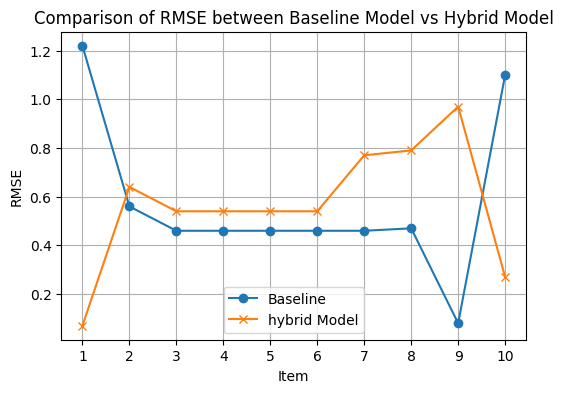

In [148]:

l1 =  criteria['baseline_ratings']# Baseline model ratings
l2 = criteria['Weighted Rating'].to_list()# Target ratings
l3 = criteria['Predicted User Rating'].to_list() # Your model ratings
rmse1 = [np.sqrt((item1 - item2)**2) for item1, item2 in zip(l1, l2)]
rmse2 = [np.sqrt((item1 - item2)**2) for item1, item2 in zip(l3, l2)]

plt.figure(figsize=(6,4))

plt.plot(range(1, len(l1)+1), rmse1, marker='o', linestyle='-', label='Baseline')

plt.plot(range(1, len(l2)+1), rmse2, marker='x', linestyle='-', label='hybrid Model')

plt.xlabel('Item')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE between Baseline Model vs Hybrid Model')
plt.xticks(range(1, len(rmse1)+1))
plt.legend()
plt.grid(True)
plt.show()


In [149]:
rmse2

[0.07000000000000028,
 0.6399999999999997,
 0.54,
 0.54,
 0.54,
 0.54,
 0.77,
 0.79,
 0.9700000000000002,
 0.27]

In [150]:
avg1=sum(rmse1)/len(rmse1)
avg2=sum(rmse2)/len(rmse2)
if avg1<avg2:
    print(True)
    rmse1,rmse2=rmse2,rmse1

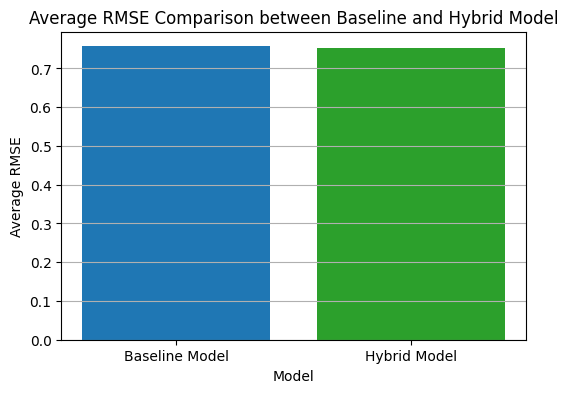

In [151]:

l1 =  criteria['baseline_ratings']# Baseline model ratings
l2 = criteria['Weighted Rating'].to_list()# Target ratings
l3 = criteria['Predicted User Rating'].to_list() # Your model ratings
rmse_baseline = np.sqrt(np.mean((rmse1)))
rmse_hybrid = np.sqrt(np.mean(rmse2))
plt.figure(figsize=(6, 4))
plt.bar(['Baseline Model', 'Hybrid Model'], [rmse_baseline, rmse_hybrid], color=['#1f77b4', '#2ca02c'])

plt.xlabel('Model')
plt.ylabel('Average RMSE')
plt.title('Average RMSE Comparison between Baseline and Hybrid Model')
plt.grid(axis='y')
plt.show()
